# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Introducción al aprendizaje profundo

### Trabajo práctico entregable 2/2

- **Estudiantes:**
    - [Chevallier-Boutell, Ignacio José](https://www.linkedin.com/in/nachocheva/) (materia completa).
    - Gastelu, Gabriela (materia completa).
    - Spano, Marcelo (materia completa).

- **Docentes:**
    - Johanna Analiz Frau (Mercado Libre).
    - Nindiría Armenta Guerrero (fyo).

---

## Librerías

In [22]:
# Importando líbrerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

from tqdm.notebook import tqdm


import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, transforms
# import torchvision.transforms as transforms

from sklearn import metrics
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Funciones útiles

In [3]:
def data_preparation(BATCH_SIZE, transform):

    # Download and load the training data
    train_set = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    # Download and load the test data
    test_set = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    return train_set, train_loader, test_set, test_loader

In [4]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true = []
        y_pred = []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true, y_pred)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true, y_pred)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true)
        all_preds.extend(y_pred)

        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds


def plotting_confusion_matrix(all_labels, all_preds, title_name=''):

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(all_labels, all_preds)
    c_m_normalized = confusion_matrix(all_labels, all_preds, normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)
    plt.suptitle(f'Confusion Matrix {title_name}', fontsize=16)
    plt.show()


def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(train_loss_history, label='train loss')
    axs[0].plot(val_loss_history, label='val loss')
    axs[0].grid()

    # Plot the training and validation accuracy
    axs[1].plot(train_acc_history, label='train acc')
    axs[1].plot(val_acc_history, label='val acc')
    axs[1].grid()
    plt.legend()
    plt.show()

In [31]:
def train(model, trainloader, loss_function, optimizer, epoch, use_tqdm=True):

    model.to(device)
    model.train()  # Activate training mode

    # Initialize the acumulated loss of the current epoch
    training_loss = 0.0
    pbar = tqdm(trainloader) if use_tqdm else trainloader
    for step, (inputs, labels) in enumerate(pbar, 1):
        # Tensors to gpu (if necessary)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients to zero
        optimizer.zero_grad()
        # Run a forward pass
        predicted_outputs = model(inputs)
        # Compute loss
        loss = loss_function(predicted_outputs, labels)
        # Backpropagation
        # Compute gradients
        loss.backward()

        # Accumulate the average loss of the mini-batch
        training_loss += loss.item()
        # Update the parameters
        optimizer.step()

        # Print statistics each 50 mini-batches
        if use_tqdm and step % 50 == 0:
          # Show number of epoch, step and average loss
          pbar.set_description(f"[{epoch}, {step}] loss: {training_loss / step:.4g}")

    epoch_training_loss = round(training_loss / len(trainloader), 4)

    return epoch_training_loss


def validation(model, dataloader, loss_function, prefix='test_', use_tqdm=True):
    model.eval()  # Activate evaluation mode
    y_true = []
    y_pred = []
    validation_loss = 0.0
    running_accuracy = 0.0
    total = 0
    # Don't calculate gradient speed up the forward pass
    with torch.no_grad():
        pbar = tqdm(dataloader) if use_tqdm else dataloader
        for (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            # Run the forward pass
            predicted_outputs = model(inputs)
            # Compute loss
            loss = loss_function(predicted_outputs, labels)
            # Accumulate the average loss of the mini-batch
            validation_loss += loss.item()

            # The label with the highest value will be our prediction
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    epoch_validation_loss = round(validation_loss / len(dataloader), 4)

    # Calculate metrics
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1 = round(metrics.f1_score(y_true, y_pred, average='macro'), 4)

    return epoch_validation_loss, (accuracy, f1)

def run_experiment(model, n_epochs, trainloader, testloader, loss_function, optimizer):

    register_performance = {
        'epoch': [],
        'epoch_training_loss': [], 'epoch_validation_loss': [],
        'validation_accuracy': [], 'validation_f1': [],
        'epoch_training_loss_2': [],
        'training_accuracy': [], 'training_f1': []
        }
    best_accuracy = 0.0

    print("Begin training...")
    # Loop through the dataset multiple times
    for epoch in range(1, n_epochs + 1):
        # Train the model
        epoch_training_loss = train(model, trainloader, loss_function, optimizer, epoch)
        epoch_training_loss_2, metrics_train = validation(model, trainloader, loss_function)
        # Test the model
        epoch_validation_loss, metrics = validation(model, testloader, loss_function)

        register_performance['epoch'].append(epoch)
        register_performance['epoch_training_loss'].append(epoch_training_loss)
        register_performance['epoch_training_loss_2'].append(epoch_training_loss_2)
        register_performance['epoch_validation_loss'].append(epoch_validation_loss)
        register_performance['training_accuracy'].append(metrics_train[0])
        register_performance['training_f1'].append(metrics_train[1])
        register_performance['validation_accuracy'].append(metrics[0])
        register_performance['validation_f1'].append(metrics[1])

            # Save the model if the accuracy is the best
        if metrics[0] > best_accuracy:
            best_model = model
            best_accuracy = metrics[0]

    # Save the results
    experiment = {
        'arquitecture': str(model),
        'optimizer': optimizer,
        'loss': str(loss_function),
        'epochs': n_epochs,
    }

    # Print the statistics of the epoch
    print(f'Completed training in {epoch} batch: ',
          'Training Loss is: ' , epoch_training_loss,
          '- Validation Loss is: ', epoch_validation_loss,
          '- Accuracy is: ', (metrics[0]),
          '- F1 is: ', (metrics[1])
          )
    return experiment, register_performance, best_model


def plot_loss(experiment):
    df_experiment = pd.DataFrame(experiment[1])

    sns.pointplot(data=df_experiment, x='epoch', y='epoch_training_loss', color='orange', label='Training')
    sns.pointplot(data=df_experiment, x='epoch', y='epoch_validation_loss', label='Validation')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def get_data_loss_metrics(experiments_set):
    df_base = pd.DataFrame()
    for i in range(len(experiments_set)):
        arquitecture = experiments_set[i][0]['arquitecture']
        model_name = arquitecture.split('(')[0]
        activation_function_name = arquitecture.split('(')[-2].split(': ')[1]
        optim = type(experiments_set[i][0]['optimizer']).__name__
        lr = experiments_set[i][0]['optimizer'].param_groups[0]['lr']
        weight_decay = experiments_set[i][0]['optimizer'].param_groups[0]['weight_decay']
        df = pd.DataFrame(experiments_set[i][1])
        df['model-activation-optimizer-lr-wd'] = f'{model_name}-{activation_function_name}-{optim}-{lr}-{weight_decay}'
        df_base = pd.concat([df_base, df])

    df_metrics = df_base.drop(columns=['epoch_training_loss', 'epoch_validation_loss'])
    df_loss = df_base.drop(columns=['validation_accuracy', 'validation_f1']).melt(id_vars=['epoch', 'model-activation-optimizer-lr-wd'],
                                                                                        value_vars=['epoch_training_loss', 'epoch_validation_loss'],
                                                                                        var_name='task', value_name='loss')
    return df_loss, df_metrics

---
# Descripción, carga y preprocesamiento del dataset

El dataset a utilizar es el **[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**, el cual es un conjunto estándar para hacer reconocimiento de imágenes. Consta de 60000 imágenes RGB de 32x32 divididas en 10 clases mutuamente excluyentes (avión, auto, pájaro, gato, ciervo, perro, rana, caballo, barco y camión), con 6000 imágenes por clase. De estas 60000 hay 50000 imágenes de entrenamiento y las otras 10000 son de evaluación.

Nuestro objetivo es entrenar una CNN que clasifique los objetos de las imágenes dentro de alguna de las 10 categorías dadas.

***Observación:*** este dataset ya está incoporado dentro de las librerías de pytorch.

In [5]:
# Tamaño de lote del baseline
BATCH_SIZE = 64

# Convertimos en tensor y normalizamos, tomando el valor medio del rango
# posible, i.e. [0; 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Obtenemos el conjunto de entrenamiento y de evaluación, junto a sus loaders
train_set, train_loader, test_set, test_loader = data_preparation(BATCH_SIZE, transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 40532125.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


---
# Modelo 1

## Definición del modelo

In [7]:
class NetwithoutPadding(nn.Module):
    def __init__(self):
        super(NetwithoutPadding, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(5 * 5 * 20, 10)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

## Baseline

In [8]:
num_epochs = 20
model = NetwithoutPadding()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, test_loader, num_epochs)

Epoch 1/20, train loss: 1.6096, train acc: 0.4227, val loss: 1.3428, val acc: 0.5227
Epoch 2/20, train loss: 1.2536, train acc: 0.5573, val loss: 1.2581, val acc: 0.5663
Epoch 3/20, train loss: 1.1461, train acc: 0.6004, val loss: 1.1537, val acc: 0.5980
Epoch 4/20, train loss: 1.0856, train acc: 0.6228, val loss: 1.0782, val acc: 0.6294
Epoch 5/20, train loss: 1.0405, train acc: 0.6386, val loss: 1.0644, val acc: 0.6299
Epoch 6/20, train loss: 1.0088, train acc: 0.6511, val loss: 1.0736, val acc: 0.6350
Epoch 7/20, train loss: 0.9861, train acc: 0.6589, val loss: 1.0132, val acc: 0.6524
Epoch 8/20, train loss: 0.9652, train acc: 0.6655, val loss: 0.9865, val acc: 0.6579
Epoch 9/20, train loss: 0.9539, train acc: 0.6680, val loss: 0.9934, val acc: 0.6569
Epoch 10/20, train loss: 0.9450, train acc: 0.6726, val loss: 1.0341, val acc: 0.6489
Epoch 11/20, train loss: 0.9349, train acc: 0.6757, val loss: 1.0275, val acc: 0.6495
Epoch 12/20, train loss: 0.9271, train acc: 0.6788, val loss: 0

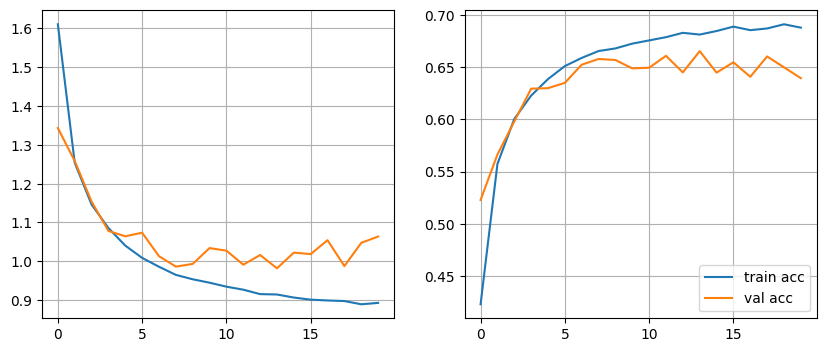

In [9]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [29]:
EPOCHS = 100

baseline_param = {
    'nH': 3,
    'AF': nn.Sigmoid(),
    'GD': optim.SGD,
    'LR': 0.1,
    'Mom': 0.9
}

Nuestro baseline con esta red pequeña (5 capas ocultas con 3 neuronas por capa), es bastante pobre. Por un lado, el costo de entrenamiento es prácticamente constante y, además, el costo de validación es muy errático. Esto se ve reflejando en las métricas, ya que oscilan a lo largo de todas las épocas, sin alncazar alguna estabilización.

In [38]:
experiments = []
experiment = run_experiment(model, 20, train_loader, test_loader, criterion, optimizer)
experiments.append(experiment)

Begin training...


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Completed training in 20 batch:  Training Loss is:  0.8398 - Validation Loss is:  0.9502 - Accuracy is:  0.6779 - F1 is:  0.6743


In [34]:
df_metrics.head()

,epoch,validation_accuracy,validation_f1,epoch_training_loss_2,training_accuracy,training_f1,model-activation-optimizer-lr-wd
0,1,0.6244,0.6280,0.9289,0.67566,0.6786,NetwithoutPadding-Linear-SGD-0.01-0.001
1,2,0.6638,0.6624,0.8052,0.72168,0.7202,NetwithoutPadding-Linear-SGD-0.01-0.001
2,3,0.6523,0.6486,0.8482,0.70482,0.7012,NetwithoutPadding-Linear-SGD-0.01-0.001


In [36]:
df_loss

,epoch,model-activation-optimizer-lr-wd,task,loss
0,1,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_training_loss,0.8693
1,2,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_training_loss,0.8720
2,3,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_training_loss,0.8582
3,1,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_validation_loss,1.0900
4,2,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_validation_loss,0.9797
5,3,NetwithoutPadding-Linear-SGD-0.01-0.001,epoch_validation_loss,1.0178


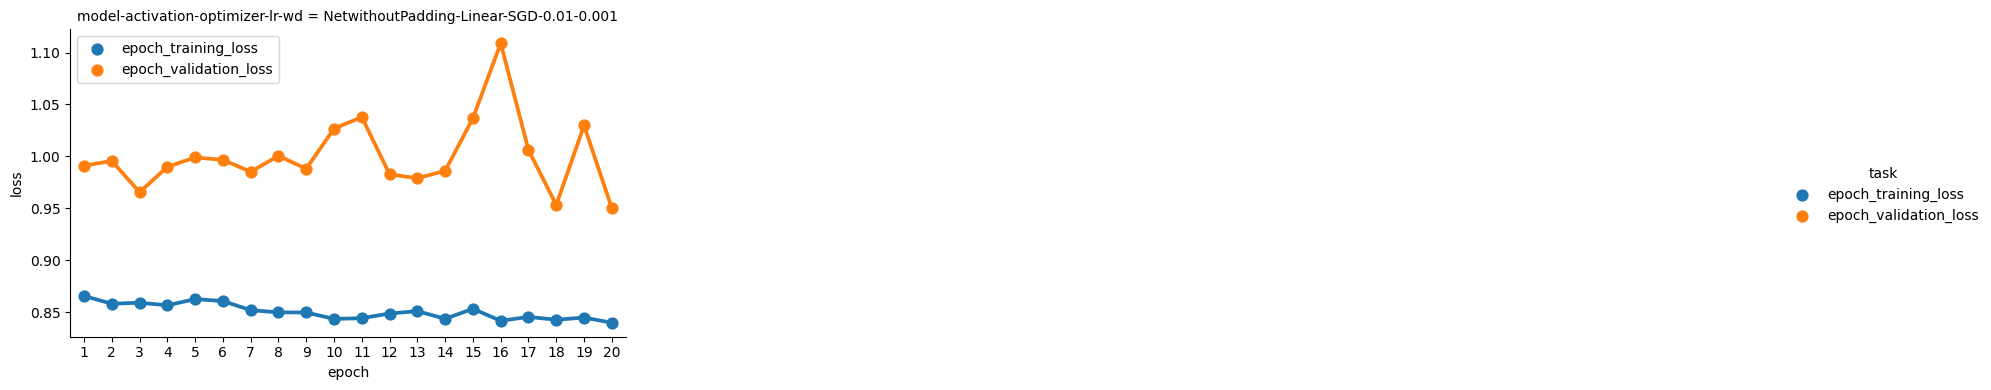

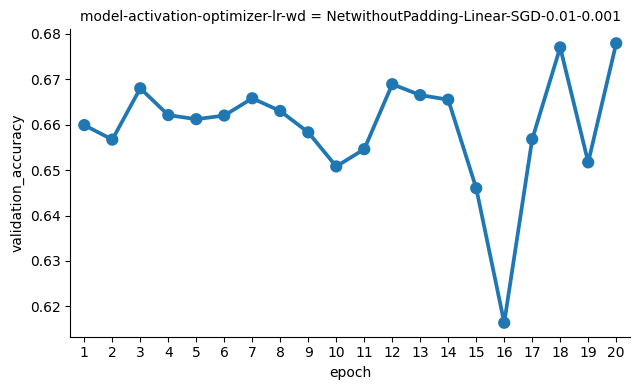

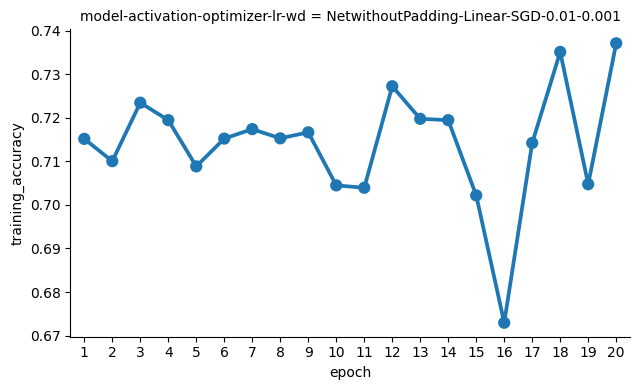

In [39]:
# Obtener y graficar las pérdidas
experiments_set = experiments
df_loss, df_metrics = get_data_loss_metrics(experiments_set)

sns.catplot(data=df_loss, x='epoch', y='loss',  hue='task', col='model-activation-optimizer-lr-wd',
            col_wrap=3, kind='point', height=4, aspect=1.5)
plt.legend()
plt.show()
sns.catplot(data=df_metrics, x='epoch', y='validation_accuracy', col='model-activation-optimizer-lr-wd',
            col_wrap=3, kind='point', height=4, aspect=1.5)
sns.catplot(data=df_metrics, x='epoch', y='training_accuracy', col='model-activation-optimizer-lr-wd',
            col_wrap=3, kind='point', height=4, aspect=1.5)
plt.show()

## Estudio de la función de activación

In [ ]:
activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU()
}

In [ ]:
# ActFunc_Exps1 = []

# for key in activation_functions.keys():
#     print(f'\n\n Corriendo con {key}')
#     model = SmallMLP(n_inputs, n_outputs, baseline_param['nH'], activation_functions[key])
#     optimizer = baseline_param['GD'](model.parameters(), lr=baseline_param['LR'], momentum=baseline_param['Mom'])
#     experiment = run_experiment(model, EPOCHS, Load_train, Load_val, loss_function, optimizer, device, use_tqdm=False)
#     ActFunc_Exps1.append(experiment)

In [ ]:
# plot_results(EPOCHS, f'SmallMLP/ActFunc_Epocas-{EPOCHS}.csv', ActFunc_Exps1)
SmallMLP_ActFunc_Epocas_100 = "https://raw.githubusercontent.com/Cheva94/Diplo_Opt/main/3_DL/Lab1/SmallMLP/ActFunc_Epocas-100.csv"
plot_results(100, SmallMLP_ActFunc_Epocas_100)

Lo primero que analizamos es qué ocurre al variar la función de activación. La sigmoide es la función de activación utilizada en el baseline. Vemos que LeakyReLU tiene un comportamiento similar a ésta. Las otras dos mejoran bastante. Tenemos que la ReLU tiene bastantes saltos en el costo de validación, correspondiéndose con saltos en las métricas, mientras que la Tanh resulta ser la de mayor estabilidad, alcanzando dicha estabilidad en una menor cantidad de épocas (aprox. 30) respecto a ReLU (aprox. 70). También se observa una mejor correspondencia entre los costes de entrenamiento y validación para Tanh que para ReLU. Decidimos quedarnos con Tanh.